<a href="https://colab.research.google.com/github/elliemci/vision-transformer-models/blob/main/image_segmentation/maskformer_seg_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train and evaluate MaskFormer image segmentation model

In [ ]:
!pip install jedi

In [ ]:
!apt-get install libcairo2-dev pkg-config python3-dev

In [ ]:
!pip install pycairo

In [ ]:
!pip install --upgrade fsspec==2024.10.0

In [ ]:
!pip install datasets transformers

In [6]:
!pip install -q albumentations

In [ ]:
!pip install -q evaluate

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%cd /content/drive/MyDrive/ColabNotebooks/ExplainableAI/image_segmentation

/content/drive/MyDrive/ColabNotebooks/ExplainableAI/image_segmentation


In [10]:
import os
import glob  # file path matching using patterns
import cv2   # OpenCV library for computer vision tasks
import numpy as np

from PIL import Image  # python imaging library for image processing
from matplotlib import pyplot as plt

## 1. Load MRI Segmentation Dataset from Hugging Face

In [ ]:
from datasets import load_dataset
from huggingface_hub import login

login(token=input("Enter Hugging Face token: "))

In [ ]:
# load_dataset("username/datasetname", split="train")
dataset = load_dataset("akar49/MRI_Segmentation-1")
dataset

In [13]:
train = dataset["train"]
test = dataset["validation"]

### Create a dictionary containg images and masks

In [14]:
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

In [15]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        """ Constructor for the image segmentation dataset, a lit of image and mask pairs. """
        self.dataset = dataset
        self.transform = transform


    def __len__(self):
      """ Gets length of dataset. """
      return len(self.dataset)

    def __getitem__(self, idx):
      """ For a given dataset index extract image and mask, convert image to RGB,
          since model is trained on RGB images, normalize pixel values to [0, 1],
          and apply transformation. """

      # extract image and mask from dataset
      image = self.dataset[idx]['image']
      mask  = self.dataset[idx]['label']

      # convert grayscale image to RGB
      org_image = np.stack((image,) * 3, axis=-1)
      # convert mask to NumPy array in order to normalize
      mask = np.array(mask)

      # pass image and mask to the transform function
      transformed = self.transform(image=org_image, mask=mask)
      trans_image = transformed['image']
      trans_mask = transformed['mask']

      # normalize pixel values to [0, 1]
      org_image = org_image/255.0
      org_mask  = mask/255.0

      # apply transformations provided
      transformed = self.transform(image=org_image, mask=org_mask)
      # access transformed image and mask
      trans_image = transformed['image']
      trans_mask = transformed['mask']

      # transpose image dimentions changing their order from (H, W, C) to (C, H, W)
      # in order to be compatable with Pythorch
      trans_image = trans_image.transpose(2, 0, 1)


      return trans_image, trans_mask, org_image, org_mask


### Image and masks resize transformation

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


original image: (512, 512, 3)
original image pixel values: min=0.0, max=1.0
transformed image: (3, 224, 224)
transformed image pixel values: min=0.0, max=0.976350540216086


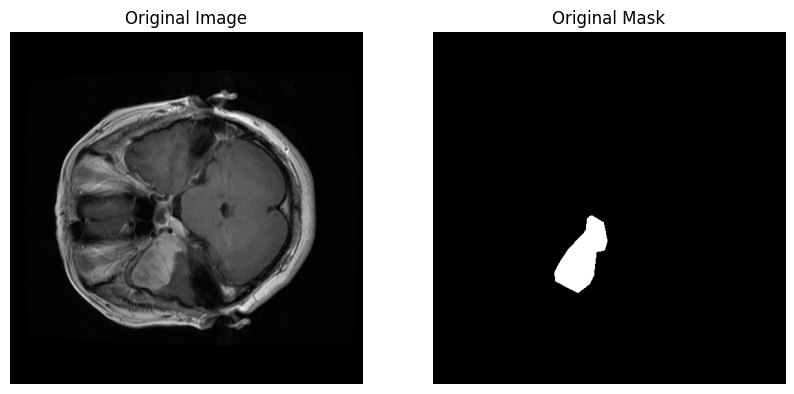

In [16]:
import albumentations as A # albumentations library used in computer vision, specifically for image augmentation

# create a transform object (optional)
transform = A.Compose([A.Resize(width=224, height=224)])

# create an instance of image segmentation custom dataset with transformations:
custom_dataset = CustomDataset(train, transform=transform)


# access first item in dataset
trans_image, trans_mask, org_image, org_mask = custom_dataset[0]

# verify transformation and normalization
print(f"original image: {org_image.shape}")
print(f"original image pixel values: min={org_image.min()}, max={org_image.max()}")
print(f"transformed image: {trans_image.shape}")
print(f"transformed image pixel values: min={trans_image.min()}, max={trans_image.max()}")

# plot original and transform images with coresponding masks
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(org_image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(org_mask, cmap='gray')
plt.axis("off")
plt.title("Original Mask")
plt.show()

### Transform training and test datasets

In [17]:
import torch
import torchvision.transforms as T

# define the training and test data transformation using Albumentations
transform = A.Compose([A.Resize(width=224, height=224)])

train_dataset = CustomDataset(train, transform=transform)
test_dataset = CustomDataset(test, transform=transform)

### Id to label mapping

In [18]:
id2label = {0:  'bg',
            1:  'tumor'}
label2id = { label: id for id, label in id2label.items() }
n_classes = len(id2label)
n_classes

2

## 2. PyTorch DataLoders

In [ ]:
from transformers import MaskFormerImageProcessor

# create a generic instance of the MaskFormerImageProcessor with specified preprocessing settings
#image_processor = MaskFormerImageProcessor(
    #ignore_index=255,       # ignore pixels with this index during processing
    #reduce_labels=False,    # the processor won't reduce the label indices to a smaller range as in multiclass segmentation
    #do_resize=False,        # already done with Albumentations
    #do_rescale=False,
    #do_normalize=False)

# load a pre-trained MaskFormerImageProcessor from HuggingFace Hub, which comes with default preprocessing settings used for training
image_processor = MaskFormerImageProcessor.from_pretrained("facebook/maskformer-swin-base-ade")
image_processor.ignore_index = 255
image_processor.reduce_labels = False
image_processor.do_resize = False
image_processor.do_rescale = False
image_processor.do_normalize = False

In [20]:
def collate_func(batch):

    """ Custom collate function for DataLoader, for an input batch list of samples,
    each containing transformed image, segmentation mask, original image, and
    original segmentation mask, returning a dictionary containing processed batch data. """

    # unpack the input batch into separate lists for images and segmentation maps
    inputs = list(zip(*batch))

    images = inputs[0]
    masks = inputs[1]

    # apply the MaskFormerImageProcessor to the batch
    batch = image_processor(
        images,
        segmentation_maps=masks,
        return_tensors="pt",
    )

    # add original images and segmentation maps to the processed batch
    batch["org_images"] = inputs[2]
    batch["org_mask"] = inputs[3]

    return batch

In [22]:
from torch.utils.data import DataLoader

# create data loaders for training and testing datasets
train_dataloader = DataLoader(train_dataset, batch_size=2, collate_fn=collate_func, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=2, collate_fn=collate_func, shuffle=False, num_workers=2)

print(f"Train dataloader number of samples: {len(train_dataloader.dataset)}")
print(f"Test dataloader number of samples: {len(test_dataloader.dataset)}")

Train dataloader number of samples: 500
Test dataloader number of samples: 200


### Test loading data

In [23]:
for batch_idx, batch in enumerate(test_dataloader):
  print(batch.keys())
  break

dict_keys(['pixel_values', 'pixel_mask', 'mask_labels', 'class_labels', 'org_images', 'org_mask'])


In [24]:
for batch_idx, batch in enumerate(train_dataloader):

  images = batch["pixel_values"]
  masks = batch["pixel_mask"]
  org_images = batch["org_images"]
  org_masks = batch["org_mask"]

  print(f"Training Batch {batch_idx}:")
  print(f"Image shape: {images.shape}")
  print(f"Mask shape: {masks.shape}")
  # training operations ...
  break # break after the first batch

# Example of iterating through the test data loader
for batch_idx, batch in enumerate(test_dataloader):

  images = batch["pixel_values"]
  masks = batch["pixel_mask"]
  org_images = batch["org_images"]
  org_masks = batch["org_mask"]

  print(f"Tasting Batch {batch_idx}:")
  print(f"Image shape: {images.shape}")
  print(f"Mask shape: {masks.shape}")
  # testing operations ...
  break  # break after the first batch

Training Batch 0:
Image shape: torch.Size([2, 3, 224, 224])
Mask shape: torch.Size([2, 224, 224])
Tasting Batch 0:
Image shape: torch.Size([2, 3, 224, 224])
Mask shape: torch.Size([2, 224, 224])


### Convert integer to string labels

In [25]:
# access class labels for first item in batch, convert the tensor into a list, itterates
# through the list of lables and converts them into string
class_labels = [id2label[label] for label in batch["class_labels"][0].tolist()]
print(class_labels)

['bg', 'tumor']


## 3. Accuracy metric

The Mean IoU quantifies the similarity between predicted and ground truth segmentation; for Intersection being the area of overlap between the predicted segmentation and the ground truth segmentation and Union the total area covered by both the predicted segmentation and the ground truth segmentation: IoU = Intersection / Union

In [26]:
import evaluate

metric = evaluate.load("mean_iou")

## 4. Load, train, evaluate model

In [27]:
from transformers import MaskFormerForInstanceSegmentation

# replace pre-trained model head
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                            id2label=id2label,
                                                            label2id=label2id,
                                                            ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# set optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# set loss function
criterion = nn.CrossEntropyLoss()

# initialize variables for tracking running loss and the number of sample
running_loss = 0.0
num_samples = 0
num_epochs = 20

### Training loop with evaluation

In [31]:
import torch
from tqdm import tqdm

class Trainer:
    def __init__(self, model, train_dataloader, test_dataloader, optimizer, device, image_processor, id2label, metric):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.optimizer = optimizer
        self.device = device
        self.image_processor = image_processor
        self.id2label = id2label
        self.metric = metric


    def train_one_epoch(self, epoch):
        """Trains the model for one epoch and returns the average training loss."""
        self.model.train()
        running_loss = 0.0
        num_samples = 0

        for idx, batch in enumerate(tqdm(self.train_dataloader)):
            self.optimizer.zero_grad()

            pixel_values = batch["pixel_values"].to(self.device, dtype=torch.float32)
            mask_labels = [labels.to(self.device) for labels in batch["mask_labels"]]
            class_labels = [labels.to(self.device) for labels in batch["class_labels"]]

            outputs = self.model(
                pixel_values=pixel_values,
                mask_labels=mask_labels,
                class_labels=class_labels,
            )

            loss = outputs.loss
            loss.backward()

            batch_size = batch["pixel_values"].size(0)
            running_loss += loss.item()
            num_samples += batch_size

            if idx % 100 == 0:
                print("Loss:", running_loss / num_samples)

            self.optimizer.step()

        epoch_loss = running_loss / num_samples
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")
        return epoch_loss

    def evaluate(self, epoch):
        """Evaluates the model on the test dataset and returns the mean IoU."""
        self.model.eval()
        # clear the evaluation metric before a new evaluation
        self.metric = evaluate.load("mean_iou")

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(self.test_dataloader)):
                pixel_values = batch["pixel_values"].to(self.device, dtype=torch.float32)

                outputs = self.model(pixel_values=pixel_values)

                original_images = batch["org_images"]
                target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]

                predicted_segmentation_maps = self.image_processor.post_process_semantic_segmentation(
                    outputs, target_sizes=target_sizes
                )

                ground_truth_segmentation_maps = batch["org_mask"]

                self.metric.add_batch(
                    references=ground_truth_segmentation_maps,
                    predictions=predicted_segmentation_maps
                )

        mean_iou = self.metric.compute(num_labels=len(self.id2label), ignore_index=0)["mean_iou"]
        print(f"Epoch {epoch + 1} Mean IoU: {mean_iou}")
        return mean_iou

    def train(self, num_epochs):
        """Trains the model for the specified number of epochs."""
        for epoch in range(num_epochs):
            train_loss = self.train_one_epoch(epoch)
            mean_iou = self.evaluate(epoch)

# Create an instance of the Trainer and start training
trainer = Trainer(model, train_dataloader, test_dataloader, optimizer, device, image_processor, id2label, metric)
trainer.train(num_epochs=num_epochs)  # Train for 20 epochs

  0%|          | 1/250 [00:00<03:39,  1.14it/s]

Loss: 0.026326561346650124


 40%|████      | 101/250 [00:27<00:36,  4.03it/s]

Loss: 0.03409979844668714


 80%|████████  | 201/250 [00:54<00:12,  4.05it/s]

Loss: 0.039997399390781695


100%|██████████| 250/250 [01:07<00:00,  3.71it/s]


Epoch 1, Loss: 0.0409


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
100%|██████████| 100/100 [00:15<00:00,  6.63it/s]
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Epoch 1 Mean IoU: 0.4472720681529817


  0%|          | 1/250 [00:00<02:35,  1.60it/s]

Loss: 0.03471022844314575


 40%|████      | 101/250 [00:27<00:38,  3.87it/s]

Loss: 0.03415878993080984


 80%|████████  | 201/250 [00:52<00:14,  3.38it/s]

Loss: 0.032517235573214384


100%|██████████| 250/250 [01:07<00:00,  3.72it/s]


Epoch 2, Loss: 0.0322


100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 2 Mean IoU: 0.46680109963144223


  0%|          | 1/250 [00:00<03:34,  1.16it/s]

Loss: 0.0319649912416935


 40%|████      | 101/250 [00:27<00:35,  4.16it/s]

Loss: 0.03241616896916144


 80%|████████  | 201/250 [00:53<00:11,  4.14it/s]

Loss: 0.0305963939945422


100%|██████████| 250/250 [01:06<00:00,  3.73it/s]


Epoch 3, Loss: 0.0307


100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 3 Mean IoU: 0.4687536503333132


  0%|          | 1/250 [00:00<02:28,  1.68it/s]

Loss: 0.022289324551820755


 40%|████      | 101/250 [00:27<00:45,  3.26it/s]

Loss: 0.027419156422561937


 80%|████████  | 201/250 [00:52<00:11,  4.09it/s]

Loss: 0.029360364005896287


100%|██████████| 250/250 [01:06<00:00,  3.78it/s]


Epoch 4, Loss: 0.0320


100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 4 Mean IoU: 0.4743424365093751


  0%|          | 1/250 [00:00<02:21,  1.76it/s]

Loss: 0.04033815860748291


 40%|████      | 101/250 [00:27<00:36,  4.09it/s]

Loss: 0.03830202904041156


 80%|████████  | 201/250 [00:54<00:13,  3.77it/s]

Loss: 0.03729281448457965


100%|██████████| 250/250 [01:06<00:00,  3.73it/s]


Epoch 5, Loss: 0.0357


100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 5 Mean IoU: 0.4697047509717439


  0%|          | 1/250 [00:00<02:39,  1.57it/s]

Loss: 0.032106850296258926


 40%|████      | 101/250 [00:28<00:49,  3.04it/s]

Loss: 0.024835804339018788


 80%|████████  | 201/250 [00:53<00:11,  4.24it/s]

Loss: 0.02514101669136713


100%|██████████| 250/250 [01:07<00:00,  3.73it/s]


Epoch 6, Loss: 0.0251


100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 6 Mean IoU: 0.46115340462811916


  0%|          | 1/250 [00:00<02:21,  1.77it/s]

Loss: 0.019288981333374977


 40%|████      | 101/250 [00:27<00:36,  4.12it/s]

Loss: 0.023869971707832106


 80%|████████  | 201/250 [00:54<00:12,  3.97it/s]

Loss: 0.02325575549470548


100%|██████████| 250/250 [01:07<00:00,  3.72it/s]


Epoch 7, Loss: 0.0230


100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 7 Mean IoU: 0.46038658288522344


  0%|          | 1/250 [00:00<02:34,  1.61it/s]

Loss: 0.02140587754547596


 40%|████      | 101/250 [00:26<00:44,  3.33it/s]

Loss: 0.02025476691894012


 80%|████████  | 201/250 [00:53<00:16,  2.92it/s]

Loss: 0.020320380477243986


100%|██████████| 250/250 [01:06<00:00,  3.76it/s]


Epoch 8, Loss: 0.0208


100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 8 Mean IoU: 0.4611821038003746


  0%|          | 1/250 [00:00<02:32,  1.63it/s]

Loss: 0.021790826693177223


 40%|████      | 101/250 [00:29<00:35,  4.19it/s]

Loss: 0.02145842199979147


 80%|████████  | 201/250 [00:55<00:12,  4.05it/s]

Loss: 0.02133835134888763


100%|██████████| 250/250 [01:08<00:00,  3.64it/s]


Epoch 9, Loss: 0.0214


100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 9 Mean IoU: 0.4642700340362113


  0%|          | 1/250 [00:00<02:24,  1.72it/s]

Loss: 0.012957250699400902


 40%|████      | 101/250 [00:26<00:43,  3.40it/s]

Loss: 0.020485093853998892


 80%|████████  | 201/250 [00:53<00:11,  4.15it/s]

Loss: 0.019700067377283206


100%|██████████| 250/250 [01:06<00:00,  3.74it/s]


Epoch 10, Loss: 0.0197


100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 10 Mean IoU: 0.4638189031881256


  0%|          | 1/250 [00:00<02:27,  1.69it/s]

Loss: 0.025509046390652657


 40%|████      | 101/250 [00:27<00:38,  3.91it/s]

Loss: 0.017964732445924


 80%|████████  | 201/250 [00:54<00:15,  3.14it/s]

Loss: 0.018069674580622076


100%|██████████| 250/250 [01:06<00:00,  3.75it/s]


Epoch 11, Loss: 0.0188


100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 11 Mean IoU: 0.4660403198195477


  0%|          | 1/250 [00:00<03:41,  1.12it/s]

Loss: 0.015750085934996605


 40%|████      | 101/250 [00:27<00:37,  3.99it/s]

Loss: 0.01748867707769617


 80%|████████  | 201/250 [00:56<00:11,  4.17it/s]

Loss: 0.018375210725790382


100%|██████████| 250/250 [01:09<00:00,  3.59it/s]


Epoch 12, Loss: 0.0184


100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 12 Mean IoU: 0.4572226250176223


  0%|          | 1/250 [00:00<02:34,  1.61it/s]

Loss: 0.02310534194111824


 40%|████      | 101/250 [00:27<00:46,  3.18it/s]

Loss: 0.017343174205115525


 80%|████████  | 201/250 [00:53<00:11,  4.08it/s]

Loss: 0.022772113838932705


100%|██████████| 250/250 [01:06<00:00,  3.78it/s]


Epoch 13, Loss: 0.0288


100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 13 Mean IoU: 0.4240242281433146


  0%|          | 1/250 [00:00<02:39,  1.57it/s]

Loss: 0.049532655626535416


 40%|████      | 101/250 [00:27<00:37,  4.02it/s]

Loss: 0.05084740185169595


 80%|████████  | 201/250 [00:54<00:12,  4.02it/s]

Loss: 0.037904673483018854


100%|██████████| 250/250 [01:07<00:00,  3.71it/s]


Epoch 14, Loss: 0.0350


100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 14 Mean IoU: 0.4656853563732302


  0%|          | 1/250 [00:00<02:16,  1.82it/s]

Loss: 0.023849207907915115


 40%|████      | 101/250 [00:26<00:44,  3.34it/s]

Loss: 0.03025192984997636


 80%|████████  | 201/250 [00:56<00:12,  4.05it/s]

Loss: 0.03174969275014021


100%|██████████| 250/250 [01:09<00:00,  3.59it/s]


Epoch 15, Loss: 0.0295


100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 15 Mean IoU: 0.460226471713693


  0%|          | 1/250 [00:00<02:32,  1.63it/s]

Loss: 0.015369807370007038


 40%|████      | 101/250 [00:28<00:37,  4.00it/s]

Loss: 0.019532604880704737


 80%|████████  | 201/250 [00:54<00:16,  2.93it/s]

Loss: 0.01969151077467707


100%|██████████| 250/250 [01:07<00:00,  3.70it/s]


Epoch 16, Loss: 0.0195


100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 16 Mean IoU: 0.4649195416188347


  0%|          | 1/250 [00:00<02:37,  1.58it/s]

Loss: 0.016131967306137085


 40%|████      | 101/250 [00:26<00:44,  3.34it/s]

Loss: 0.028462592848936225


 80%|████████  | 201/250 [00:53<00:12,  4.05it/s]

Loss: 0.026351270495232806


100%|██████████| 250/250 [01:07<00:00,  3.72it/s]


Epoch 17, Loss: 0.0250


100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 17 Mean IoU: 0.45529726300525647


  0%|          | 1/250 [00:00<02:17,  1.81it/s]

Loss: 0.012605337426066399


 40%|████      | 101/250 [00:27<00:36,  4.12it/s]

Loss: 0.017073886137049975


 80%|████████  | 201/250 [00:55<00:19,  2.55it/s]

Loss: 0.017499326774618816


100%|██████████| 250/250 [01:08<00:00,  3.65it/s]


Epoch 18, Loss: 0.0180


100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 18 Mean IoU: 0.4440889775038769


  0%|          | 1/250 [00:00<03:47,  1.09it/s]

Loss: 0.019520029425621033


 40%|████      | 101/250 [00:27<00:36,  4.13it/s]

Loss: 0.016699654889283794


 80%|████████  | 201/250 [00:55<00:11,  4.10it/s]

Loss: 0.016630341465682236


100%|██████████| 250/250 [01:08<00:00,  3.65it/s]


Epoch 19, Loss: 0.0164


100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 19 Mean IoU: 0.46071184017078526


  0%|          | 1/250 [00:00<02:29,  1.67it/s]

Loss: 0.017417196184396744


 40%|████      | 101/250 [00:27<00:44,  3.38it/s]

Loss: 0.01663882445802193


 80%|████████  | 201/250 [00:53<00:13,  3.52it/s]

Loss: 0.01532930195961722


100%|██████████| 250/250 [01:06<00:00,  3.75it/s]


Epoch 20, Loss: 0.0153


100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 20 Mean IoU: 0.4616815700964695


In [35]:
# upload trained model to Huggingface hub
#model.push_to_hub("elliemci/Maskformer_MRIseg_model")
# save model weigths
model.save_pretrained("maskformer_tumor_segmentation")

# load trained model weigths
trained_model = MaskFormerForInstanceSegmentation.from_pretrained("maskformer_tumor_segmentation")

Backbone maskformer-swin is not a supported model and may not be compatible with MaskFormer. Supported model types: resnet,swin


In [42]:
!ls

data_preproces.ipynb	       mri_data_seg		     transformer_seg_training.ipynb
maskformer_seg_training.ipynb  segformer_tumor_segmentation
maskformer_tumor_segmentation  segmentation_dataset


## 5. Inference

Load 10 test images, predict and display original image with ground truth mask and predicted mask

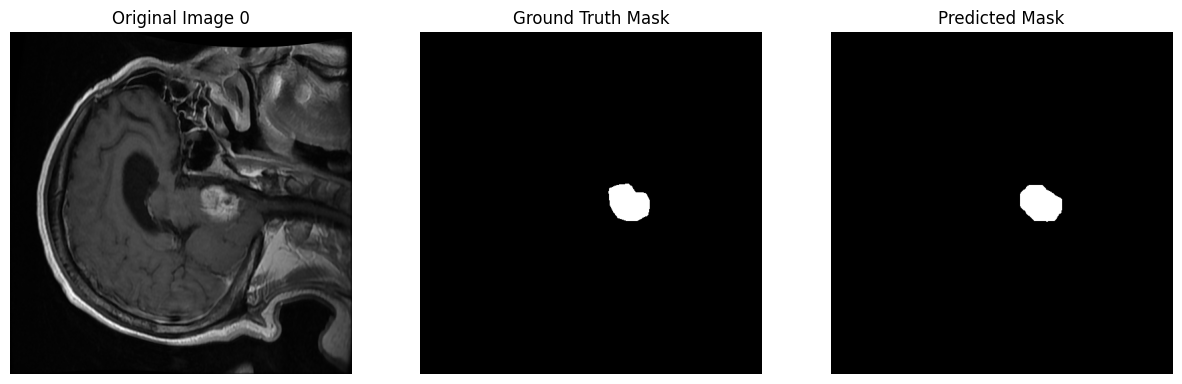

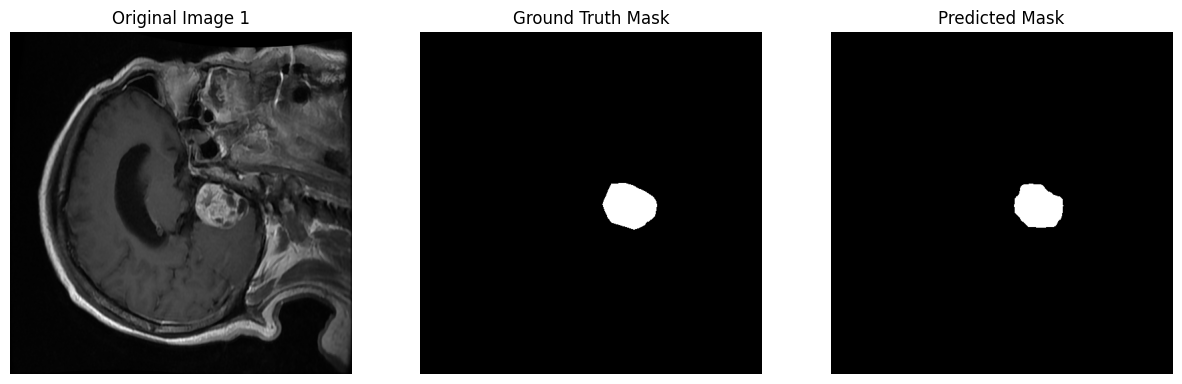

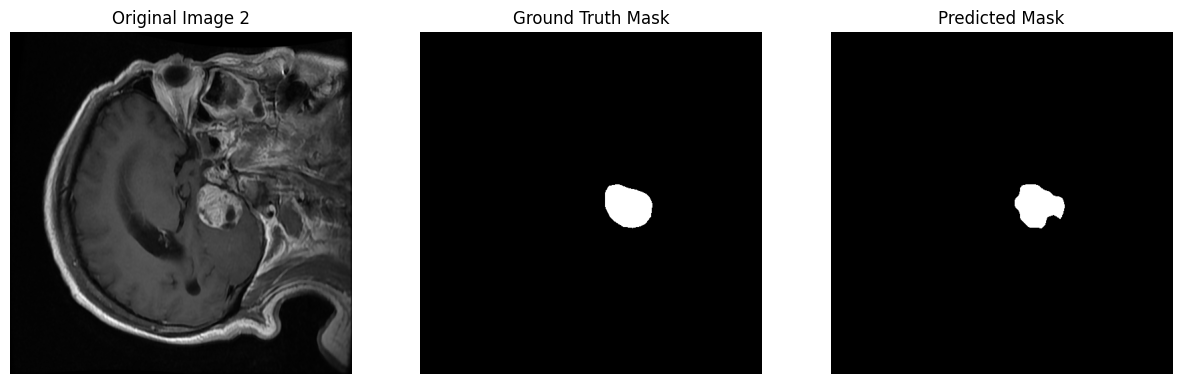

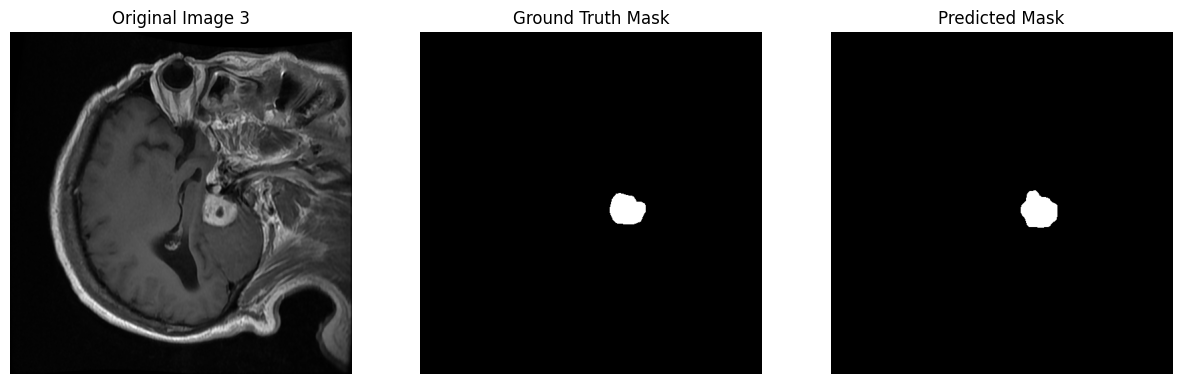

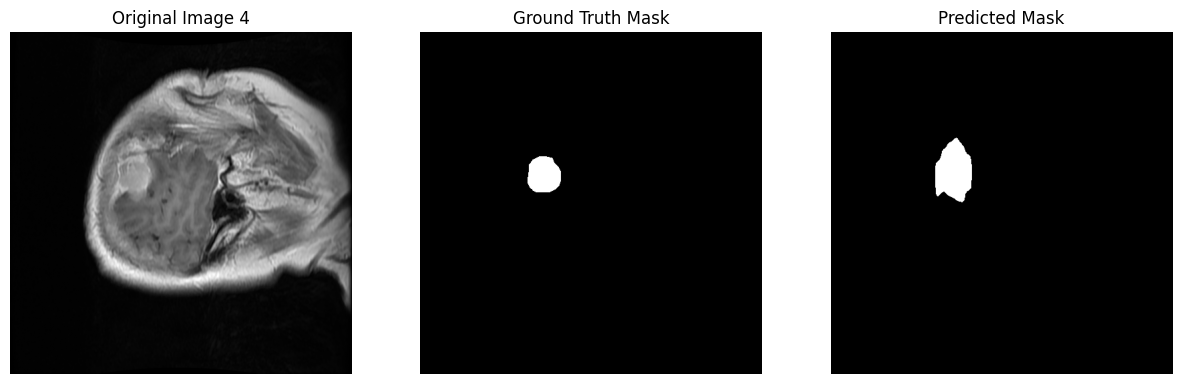

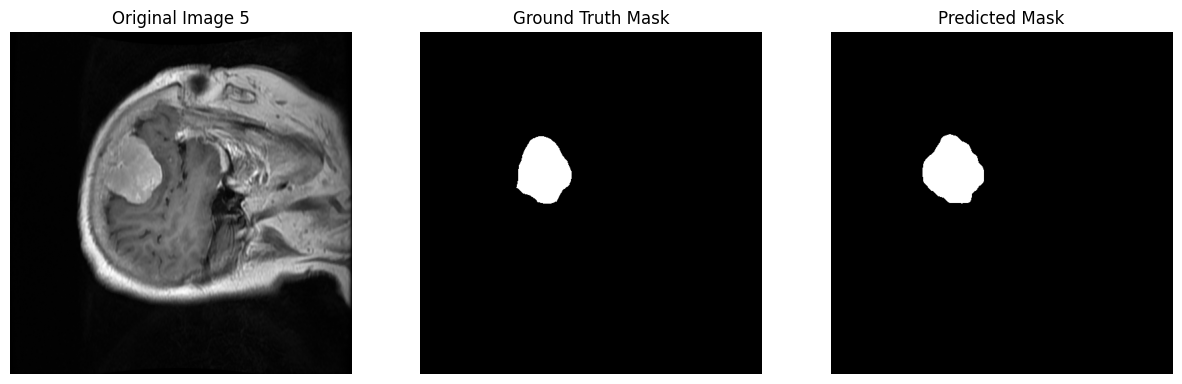

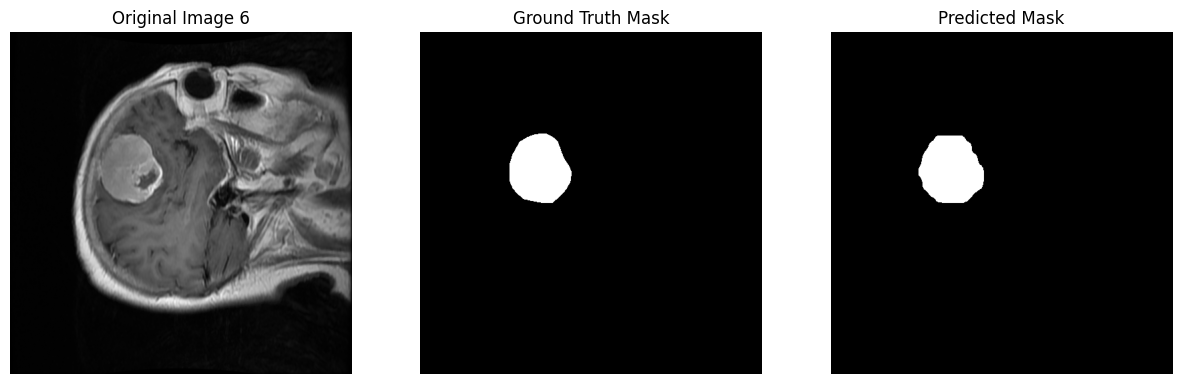

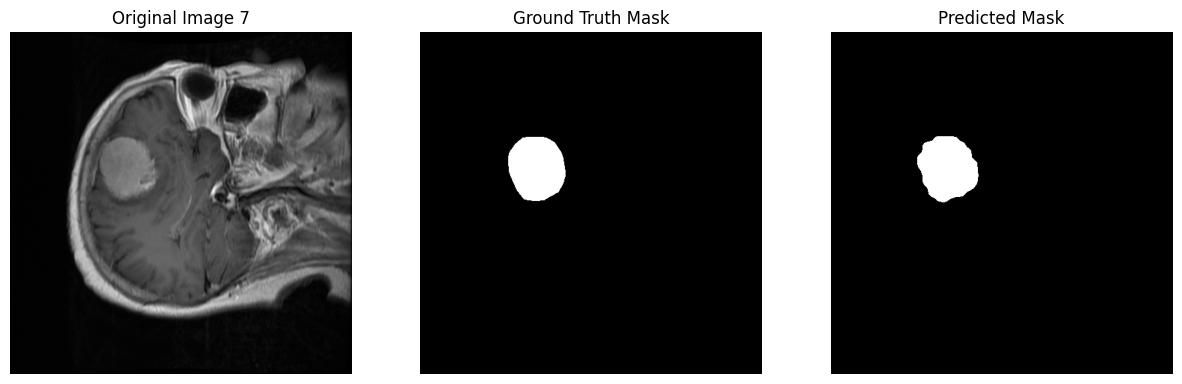

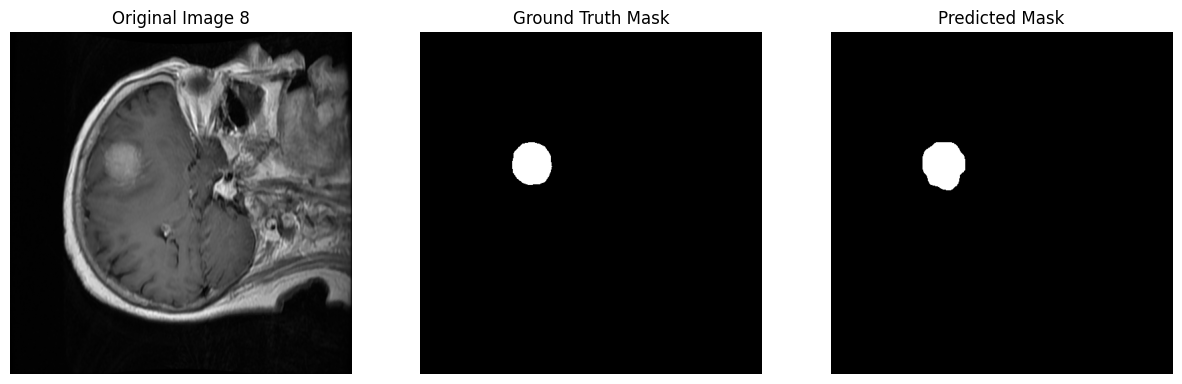

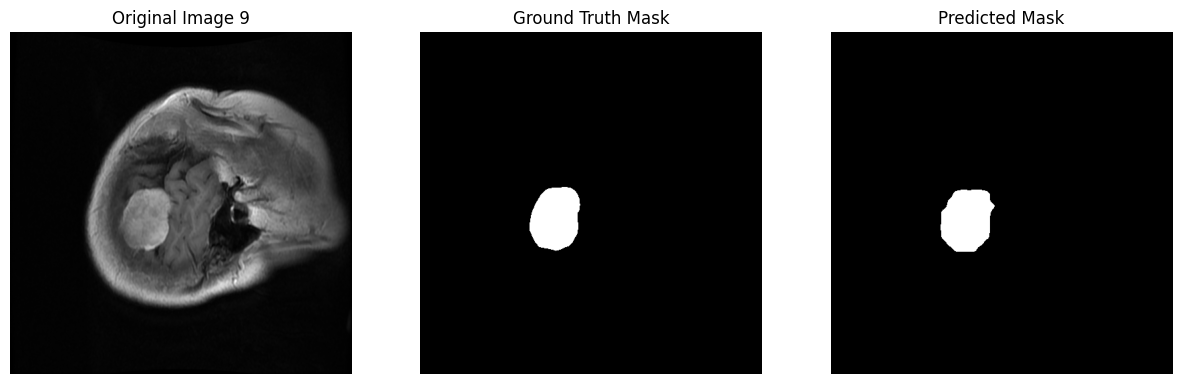

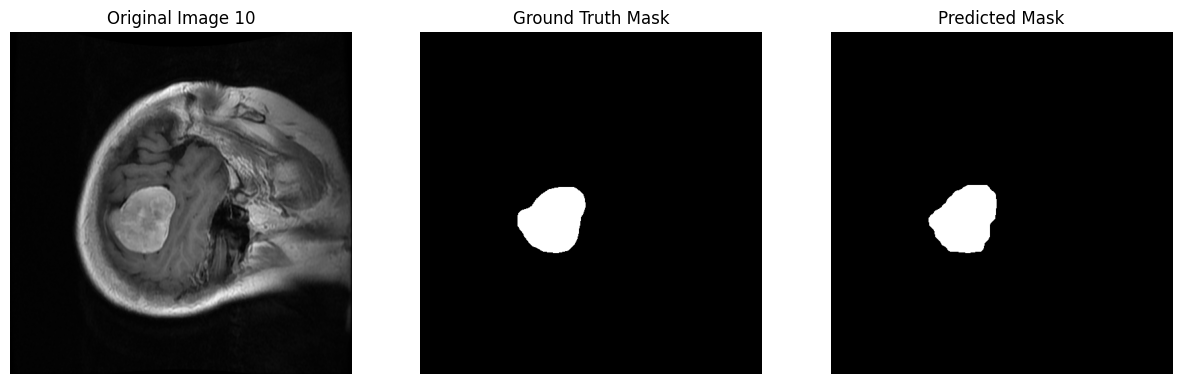

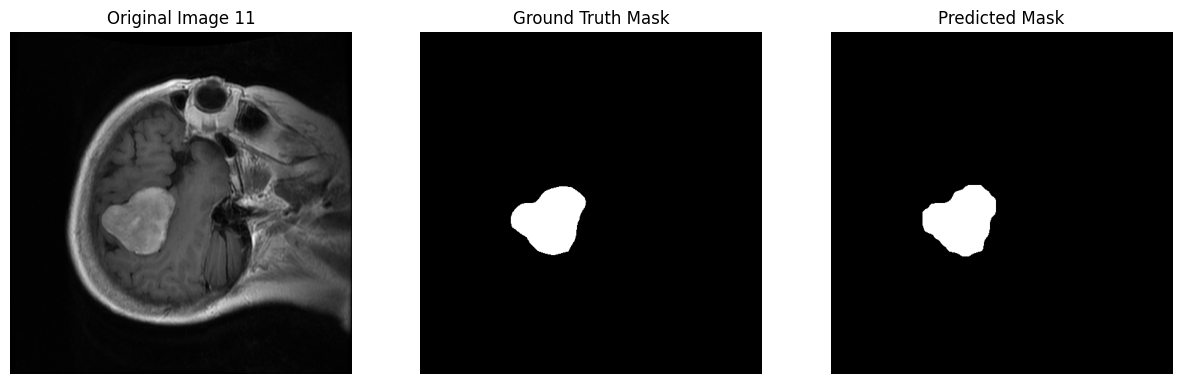

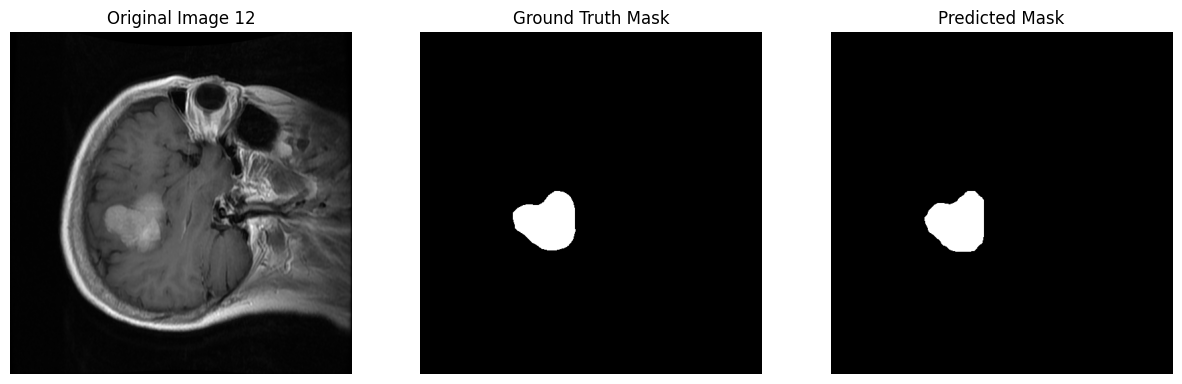

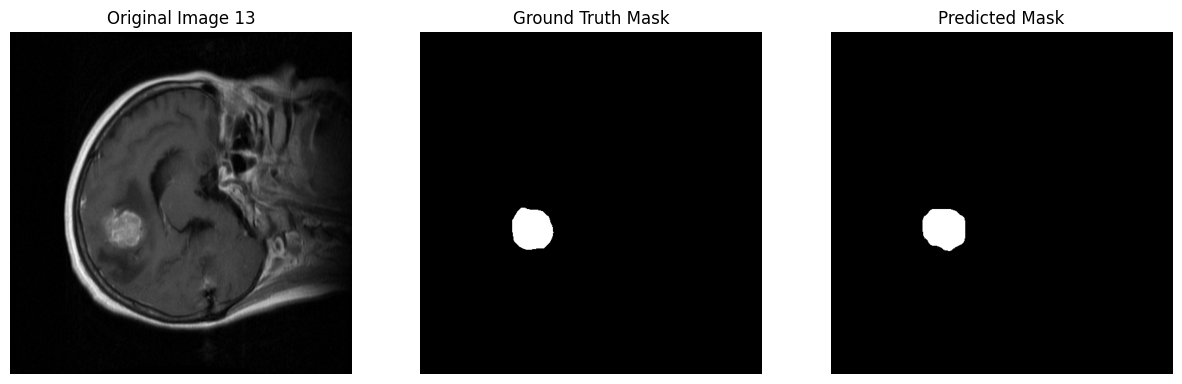

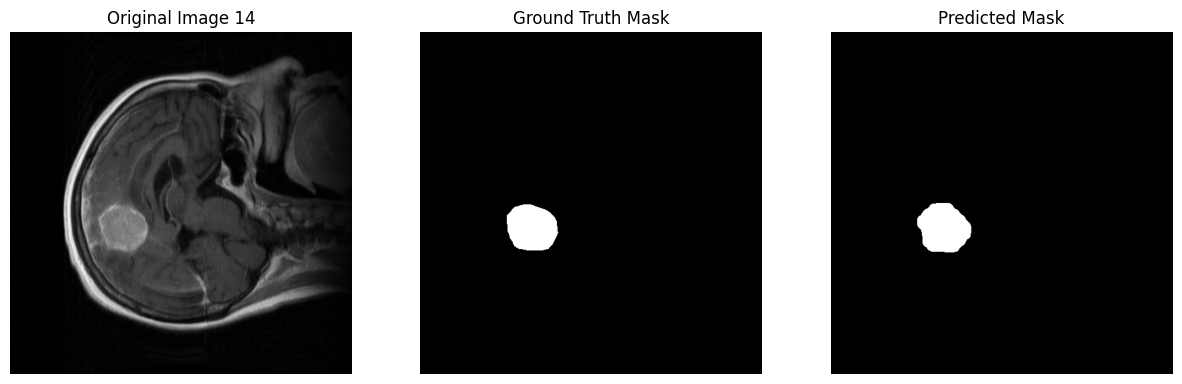

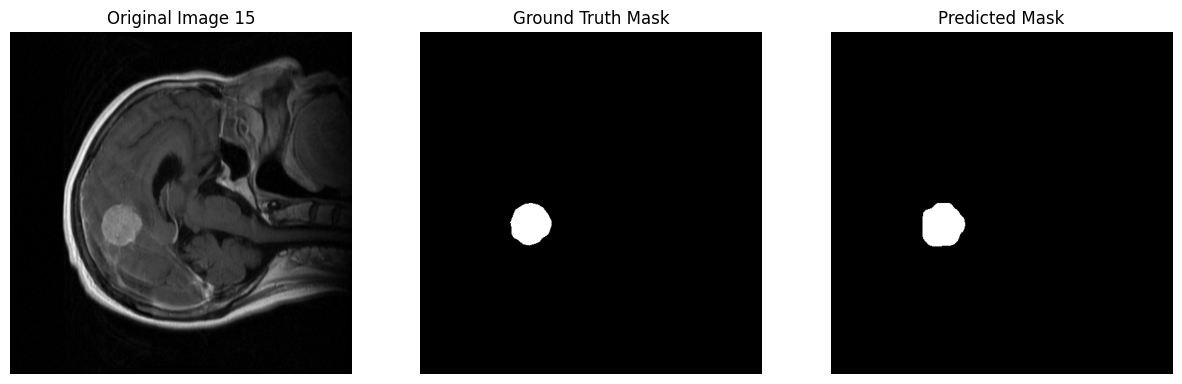

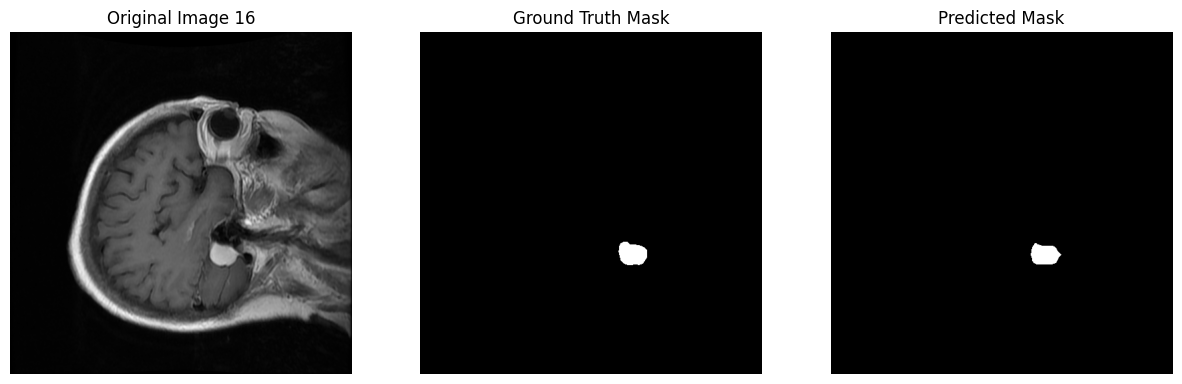

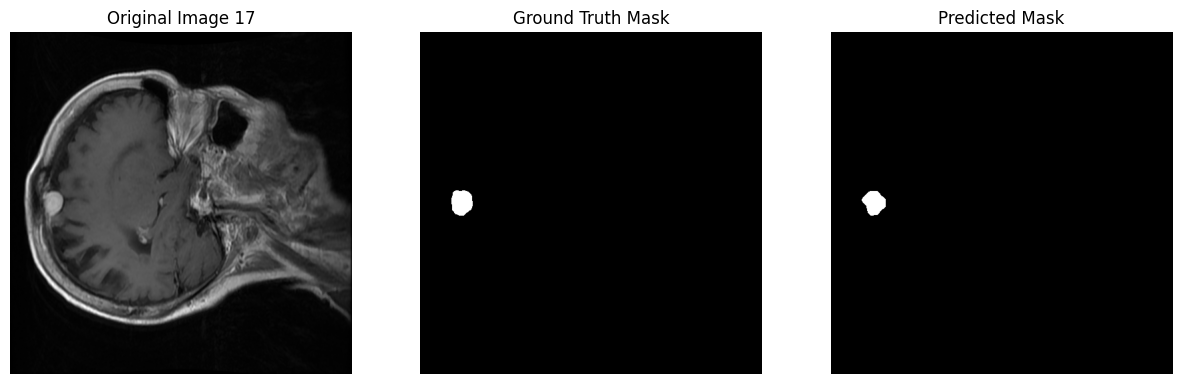

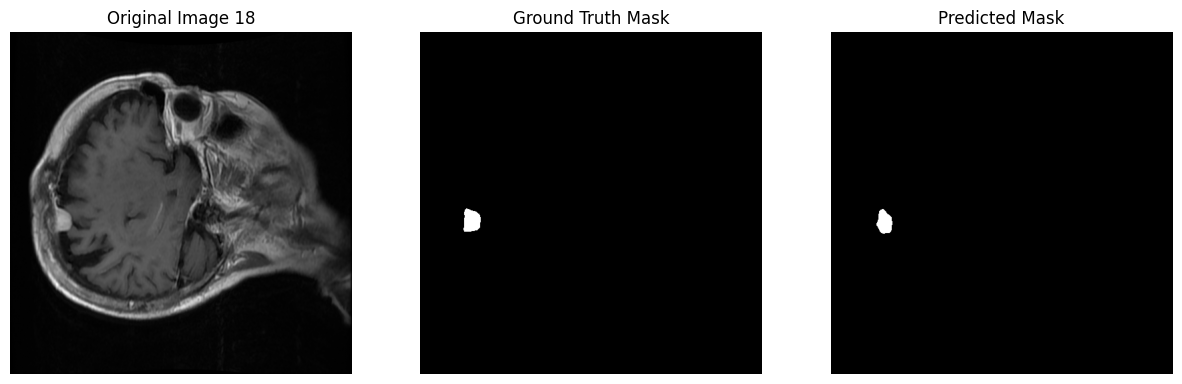

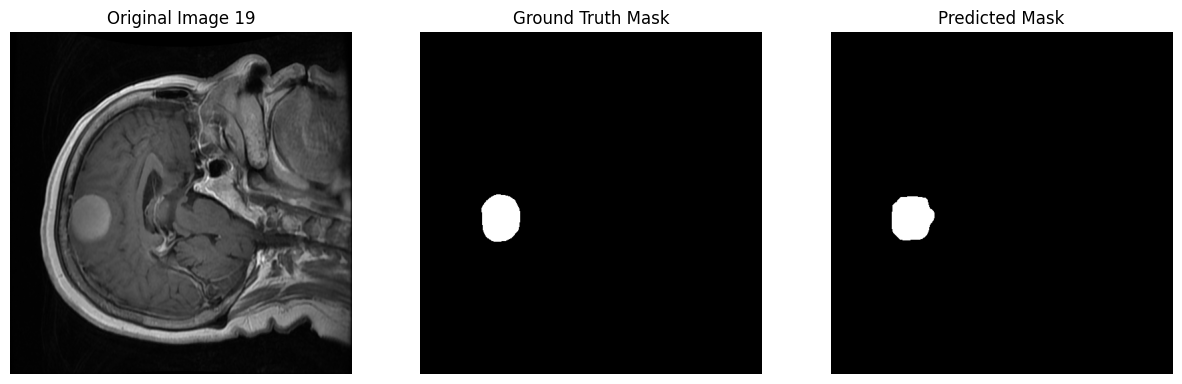

In [40]:
# prompt: load 10 test images, predict and display original image with ground truth mask and predicted mask

import matplotlib.pyplot as plt

# Assuming 'test_dataloader' and 'trained_model' are already defined and loaded

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.to(device)

trained_model.eval()

num_test_images = 10
for i, batch in enumerate(test_dataloader):
    if i >= num_test_images:
        break

    pixel_values = batch["pixel_values"].to(device, dtype=torch.float32)
    with torch.no_grad():
      outputs = trained_model(pixel_values=pixel_values)

    original_images = batch["org_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]

    predicted_segmentation_maps = image_processor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)
    ground_truth_segmentation_maps = batch["org_mask"]

    for j in range(len(original_images)):  # Iterate through images in the batch
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(original_images[j])
        plt.title(f"Original Image {i * len(original_images) + j}")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(ground_truth_segmentation_maps[j], cmap="gray")  # Display as grayscale
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_segmentation_maps[j].cpu().numpy(), cmap="gray")  # Display as grayscale
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()